In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
from sklearn.metrics import mean_absolute_percentage_error
cf.go_offline()

## Data Collection and Data Manipulation

In [52]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [53]:
googl = get_finance_data('googl')

In [54]:
googl

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,167.312317,172.672668,166.166168,170.455460,10403386
2009-02-03,171.456451,171.671677,167.082077,170.395401,13099887
2009-02-04,170.205200,177.397400,169.754761,171.671677,13621165
2009-02-05,170.625626,177.867874,168.668671,177.037033,14514271
2009-02-06,178.408401,187.092087,177.897903,185.825821,14062124
...,...,...,...,...,...
2021-10-15,2832.290039,2834.360107,2815.100098,2827.360107,1512900
2021-10-18,2821.530029,2855.919922,2821.389893,2855.560059,1019800
2021-10-19,2867.750000,2873.250000,2852.000000,2864.739990,1008200


In [55]:
googl_close = googl[['Close']]

## Data Visualization

In [6]:
googl_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

In [7]:
googl['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

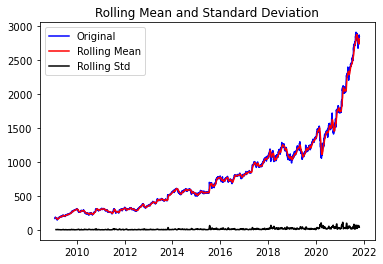

Results of dickey fuller test
Test Statistics                   4.042390
p-value                           1.000000
No. of lags used                 26.000000
Number of observations used    3177.000000
critical value (1%)              -3.432410
critical value (5%)              -2.862450
critical value (10%)             -2.567255
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(googl_close)

<Figure size 432x288 with 0 Axes>

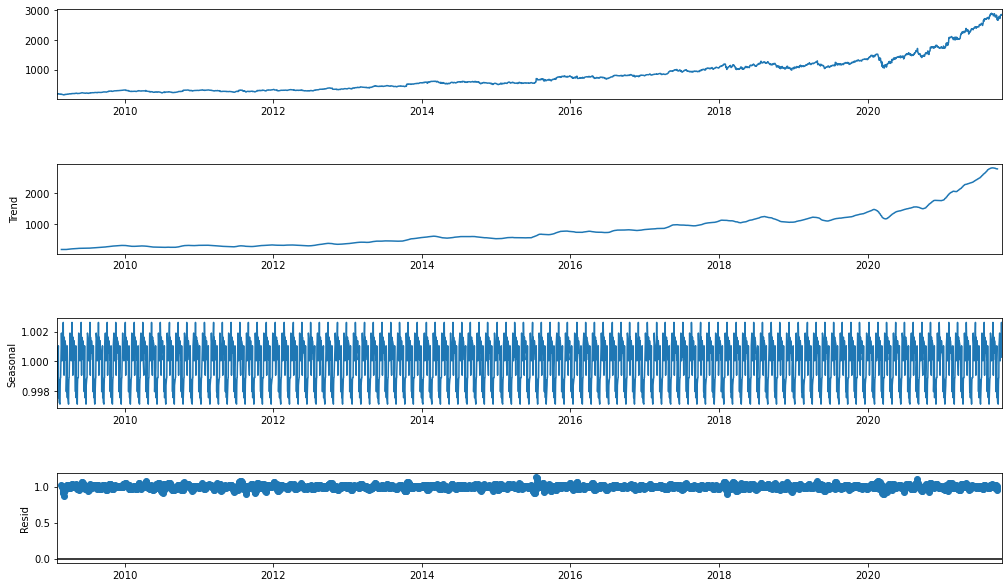

In [9]:
result = seasonal_decompose(googl_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Modeling

In [10]:
googl_close

,Close
Date,
2009-02-02,170.455460
2009-02-03,170.395401
2009-02-04,171.671677
2009-02-05,177.037033
2009-02-06,185.825821
...,...
2021-10-15,2827.360107
2021-10-18,2855.560059
2021-10-19,2864.739990


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not

In [11]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(googl_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 4.042390
p-value: 1.000000


## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

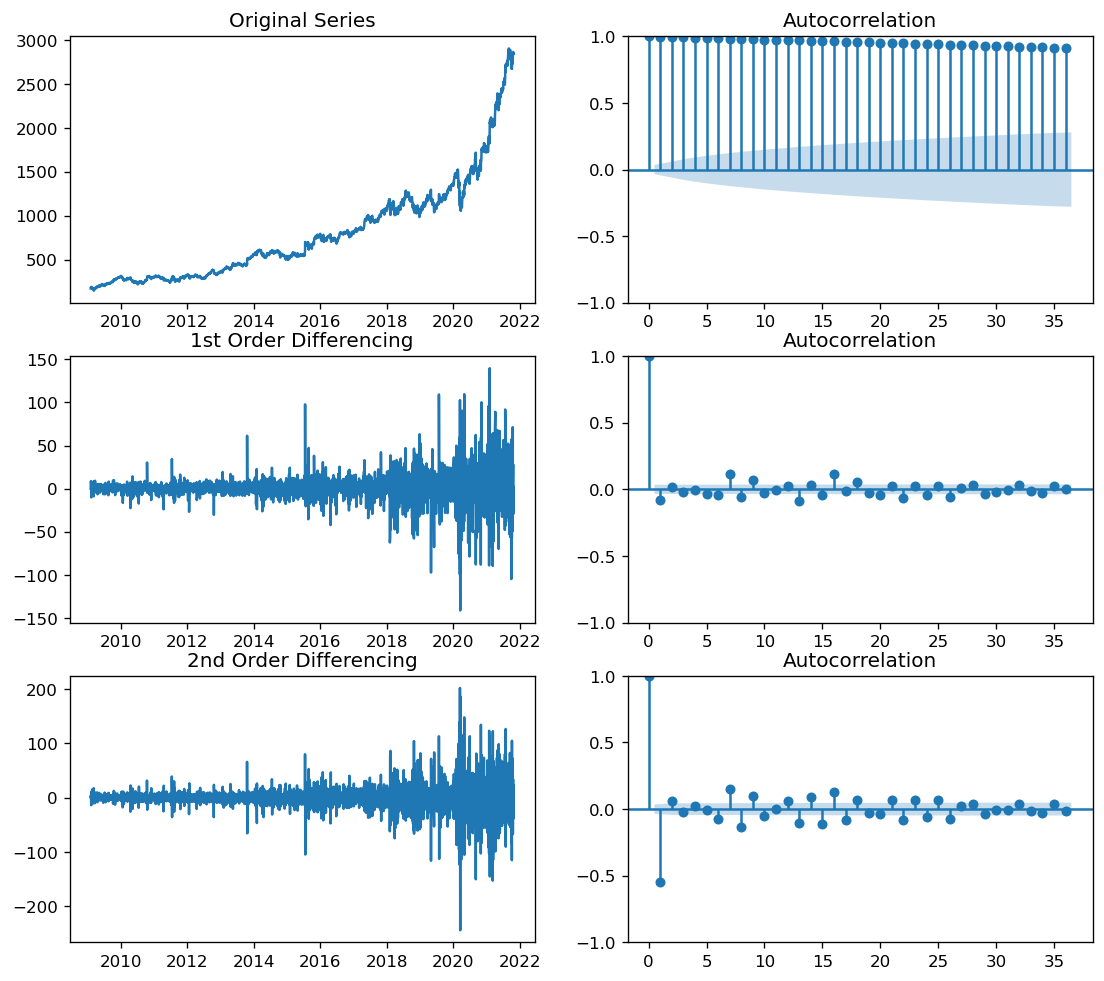

In [12]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(googl_close); axes[0, 0].set_title('Original Series')
plot_acf(googl_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(googl_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(googl_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(googl_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(googl_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



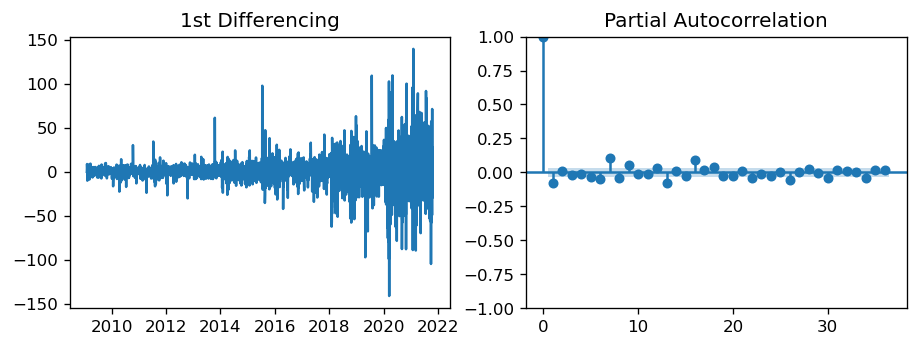

In [13]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(googl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(googl_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significant since is well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

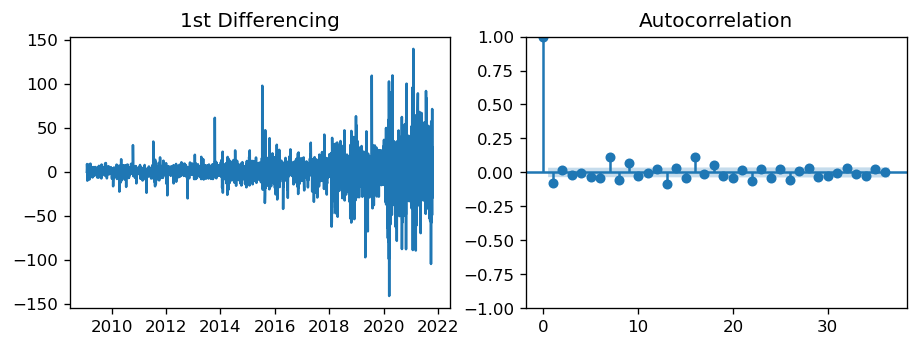

In [14]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(googl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(googl_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA Model

## Train-Test Split

In [15]:
n = int(len(googl_close) * 0.80)
train = googl_close[:n]
test = googl_close[n:]

In [16]:
train

,Close
Date,
2009-02-02,170.455460
2009-02-03,170.395401
2009-02-04,171.671677
2009-02-05,177.037033
2009-02-06,185.825821
...,...
2019-04-02,1205.540039
2019-04-03,1210.810059
2019-04-04,1219.449951


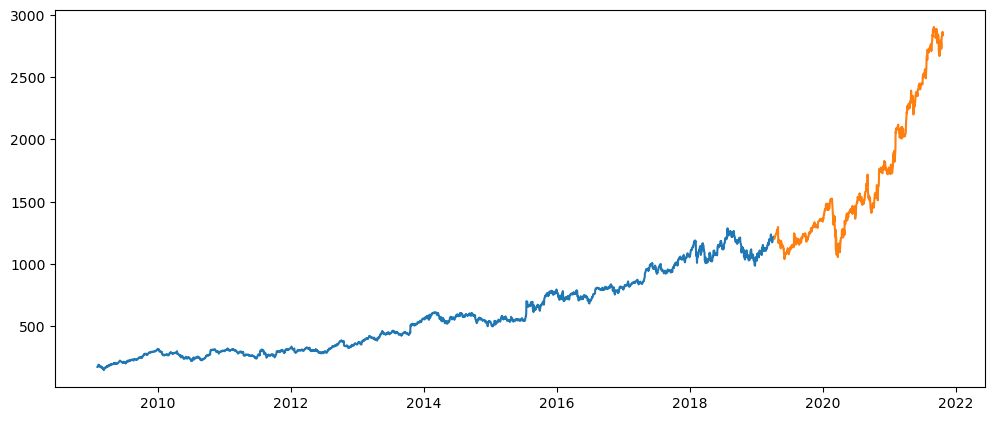

In [17]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

## Prediction

In [18]:
model = SARIMAX(googl_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -13375.590
Date:                Thu, 28 Oct 2021   AIC                          26757.181
Time:                        08:28:06   BIC                          26775.396
Sample:                             0   HQIC                         26763.711
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3233      0.092     -3.519      0.000      -0.503      -0.143
ma.L1          0.2482      0.094      2.640      0.008       0.064       0.432
sigma2       247.9966      2.236    110.889      0.0

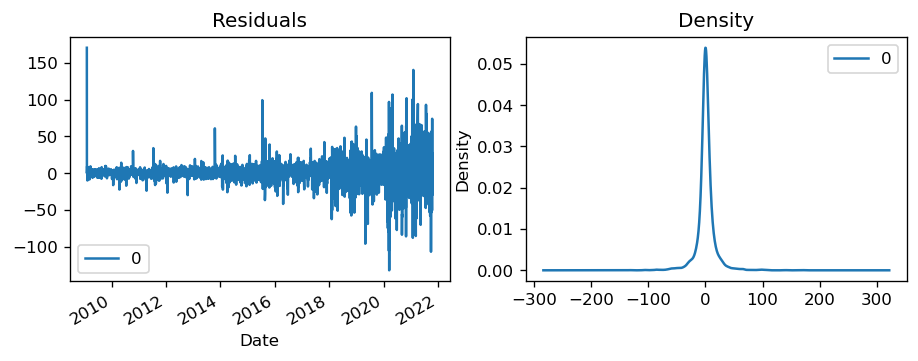

In [19]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [20]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

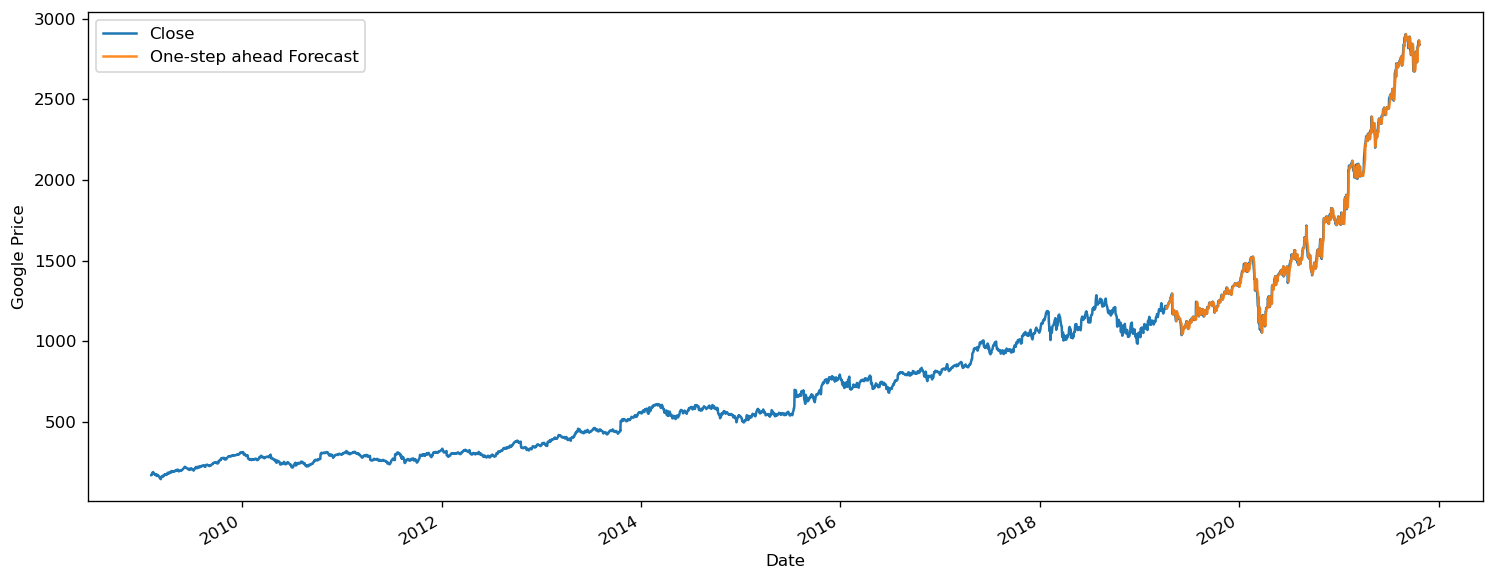

In [21]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = googl_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Google Price')
plt.legend()

plt.show();

In [22]:
value_forecasted = pred
value_truth = googl_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 29.53


In [23]:
mean_absolute_percentage_error(value_truth, value_forecasted)

0.012820165352560857

# PMDARIMA

In [24]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

In [25]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [26]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18818.109, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18818.888, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18818.783, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18820.749, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18817.139, Time=0.99 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18818.235, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18818.262, Time=1.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=18816.575, Time=0.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=18818.357, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=18811.492, Time=2.21 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=18808.170, Time=1.65 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=18819.143, Time=0.95 sec
 ARIMA(2,1,4)(0,0,0)[0] interce

In [27]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -9384.053
Date:                Thu, 28 Oct 2021   AIC                          18784.106
Time:                        08:29:03   BIC                          18830.894
Sample:                             0   HQIC                         18801.071
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0207      0.013      1.603      0.109      -0.005       0.046
ar.L1          0.2023      0.014     14.039      0.000       0.174       0.231
ar.L2         -0.2252      0.011    -20.257      0.0

In [28]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 895.8615733002913
SMAPE: 1.3050697623310714


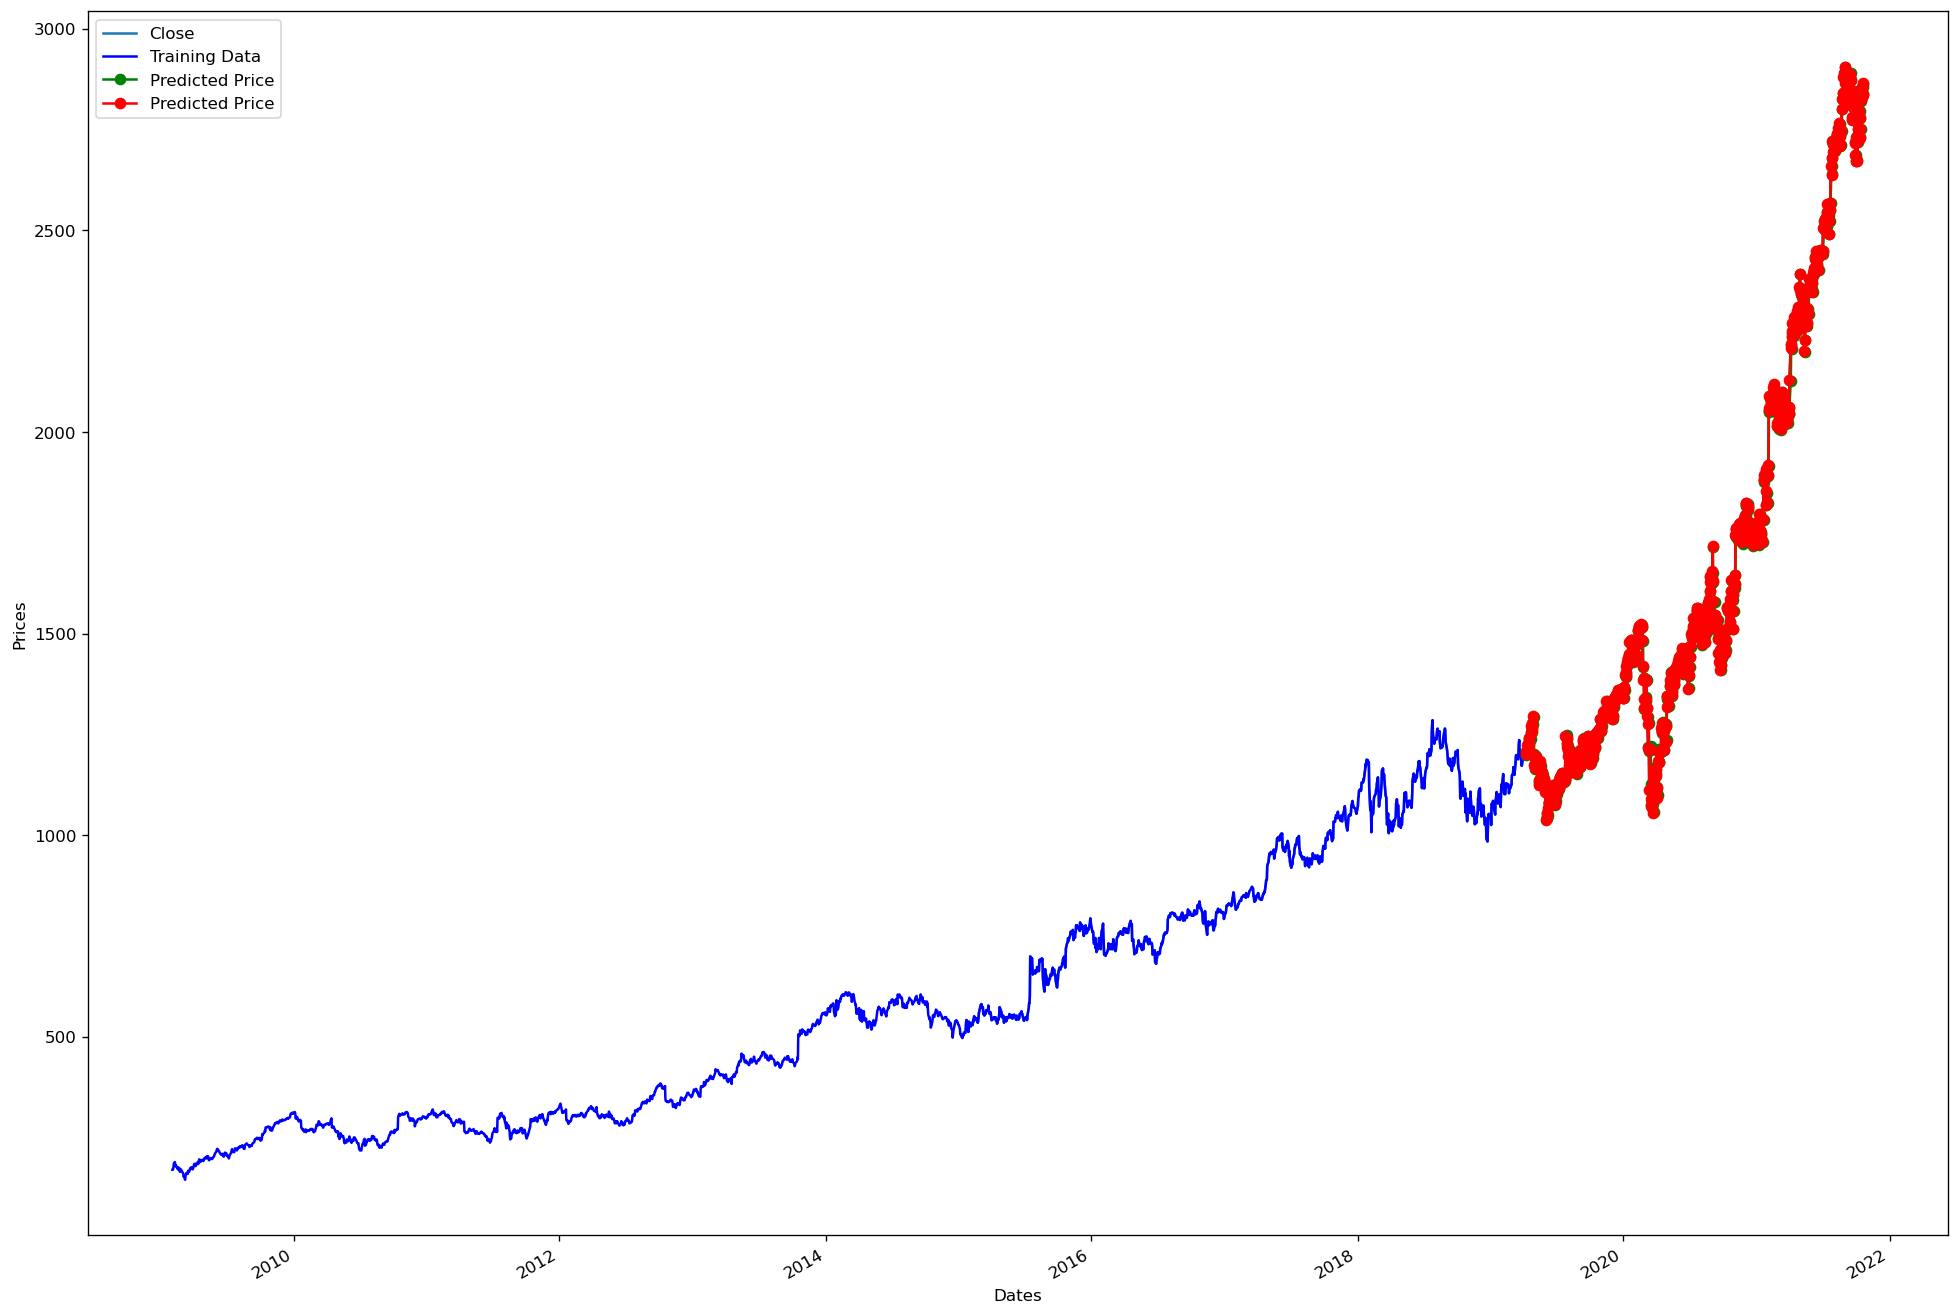

In [29]:
ax = googl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [30]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(895.8615733002913), 2)))

The Root Mean Squared Error of prediction is 29.93


## SARIMAX PMDARIMA

In [31]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=24569.315, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=19755.768, Time=2.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=22276.204, Time=3.13 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=24632.468, Time=0.10 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=20398.173, Time=0.43 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=19376.427, Time=9.46 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=17.58 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=5.04 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=24537.178, Time=9.32 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=19370.574, Time=18.97 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=19750.589, Time=4.87 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=27.70 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=11.12 sec
 ARIMA(3,0,0)(2,1,0)[12] interc

In [32]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 1167.7160854327344
SMAPE: 1.5224362444073194


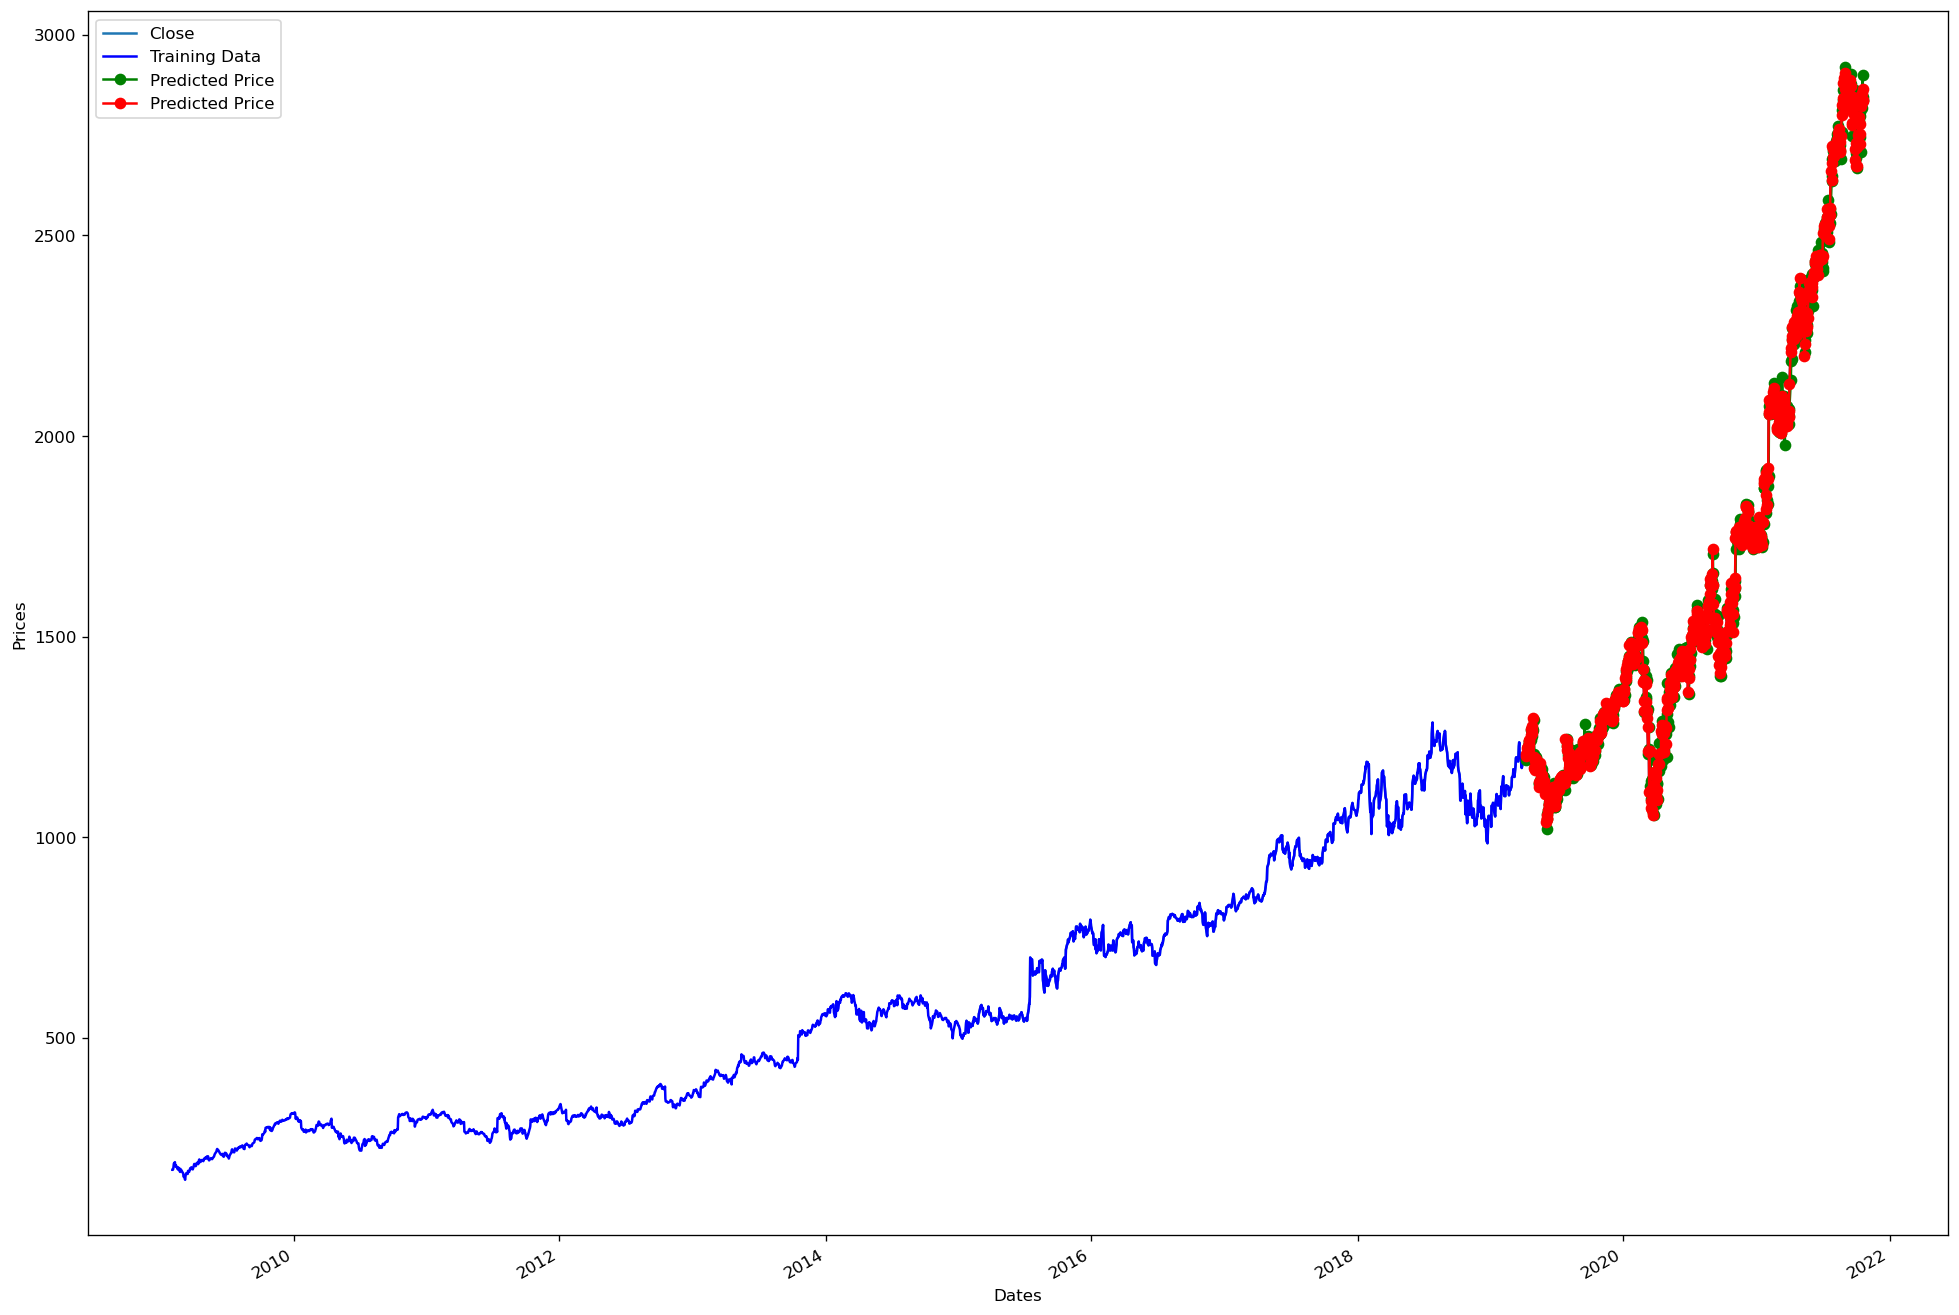

In [33]:
ax = googl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [46]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(1167.7160854327344), 2)))

The Root Mean Squared Error of prediction is 34.17


## FBPROPHET

In [56]:
googl_close = googl[['Close']]

In [57]:
googl = googl_close.reset_index()

In [58]:
googl

,Date,Close
0,2009-02-02,170.455460
1,2009-02-03,170.395401
2,2009-02-04,171.671677
3,2009-02-05,177.037033
4,2009-02-06,185.825821
...,...,...
3199,2021-10-15,2827.360107
3200,2021-10-18,2855.560059
3201,2021-10-19,2864.739990
3202,2021-10-20,2835.379883


In [59]:
googl.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
googl['ds'] = pd.to_datetime(googl['ds'])
googl['y']=googl['y'].astype(float)

In [60]:
df_prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
df_prophet.fit(googl)

In [61]:

fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


In [62]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

  0%|          | 0/18 [01:43<?, ?it/s]


In [63]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,3116.693003,2900.108749,3305.570522
3565,2022-10-18,3118.932386,2922.601206,3310.824957
3566,2022-10-19,3121.422677,2907.929586,3308.800411
3567,2022-10-20,3122.967190,2909.028342,3307.500805
3568,2022-10-21,3124.652094,2924.779290,3312.252381


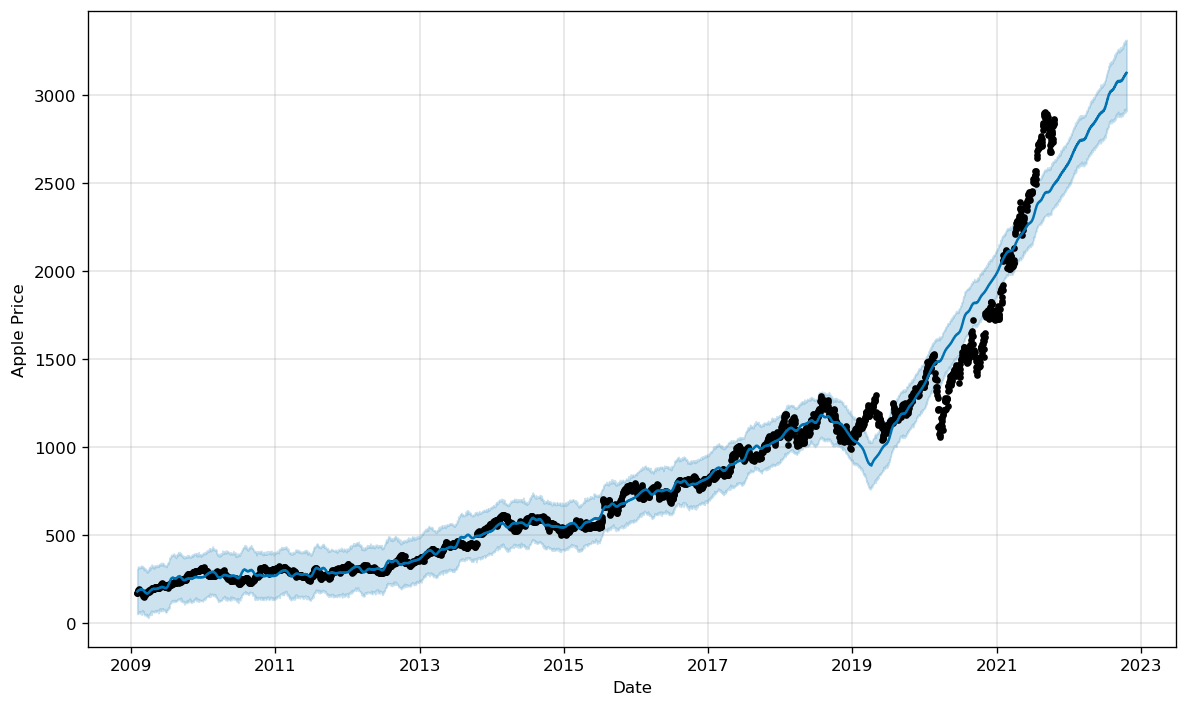

In [64]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Apple Price');

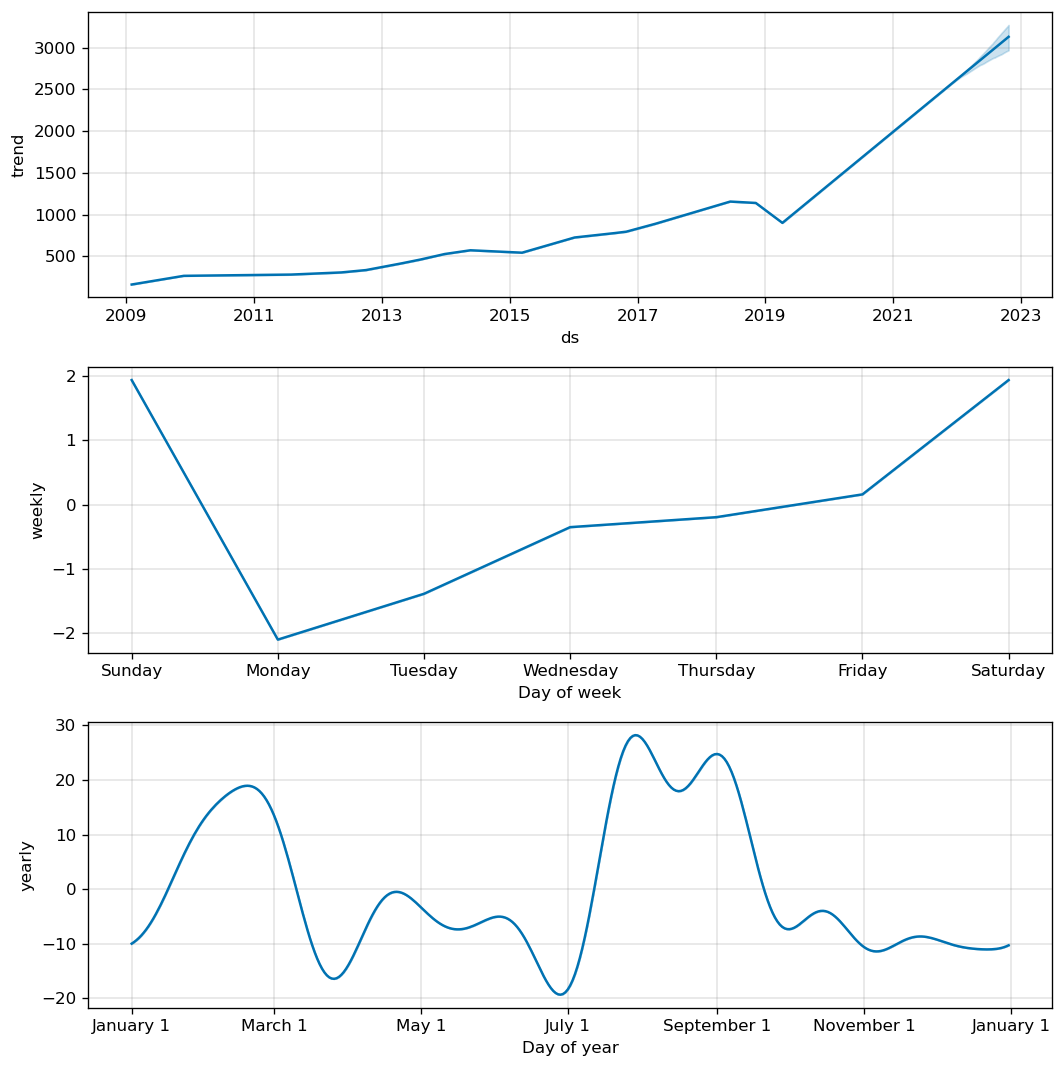

In [65]:

fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In [66]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [05:11<00:00, 17.30s/it]


In [67]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,9533.165887,97.637933,75.797365,0.090627,0.072958,0.090194,0.173831
1,37 days 00:00:00,9829.981433,99.146263,77.020776,0.091802,0.074361,0.091358,0.168142
2,37 days 12:00:00,9874.757259,99.371813,77.207000,0.091714,0.073616,0.091337,0.166561
3,38 days 00:00:00,9988.573809,99.942853,77.942245,0.092662,0.074361,0.092301,0.161188
4,38 days 12:00:00,9974.728530,99.873563,77.891361,0.092563,0.074087,0.092241,0.159924


## Result

The ARIMA model performed the best with the lowest rmse